GitHub Link : https://github.com/Thorlapati3108/Comparative-Study-of-CNNs-and-Transfer-Learning-Using-ResNet50-for-Image-Classification.git

IMPORT REQUIRED LIBRARIES

In [1]:
# IMPORT LIBRARIES

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


UNZIP DATASET

In [2]:
# UNZIP DATASET


ZIP_PATH = "Intel Image Classification.zip"   
EXTRACT_PATH = "dataset"

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

print("Dataset extracted to:", EXTRACT_PATH)


Dataset extracted to: dataset


In [3]:
# VERIFY FOLDER STRUCTURE

print("Main directories:", os.listdir(EXTRACT_PATH))


Main directories: ['seg_pred', 'seg_test', 'seg_train']


LOAD DATASET

In [4]:
print("TRAIN ROOT:", os.listdir(EXTRACT_PATH))
print("seg_train contents:", os.listdir(os.path.join(EXTRACT_PATH, "seg_train")))


TRAIN ROOT: ['seg_pred', 'seg_test', 'seg_train']
seg_train contents: ['seg_train']


In [5]:
# LOAD DATASET

# Define input image size (ResNet50 expects 224x224 images)
IMG_SIZE = (224, 224)

BATCH_SIZE = 32

# Define training and testing directory paths
# (dataset extracted from ZIP file into EXTRACT_PATH)
train_dir = os.path.join(EXTRACT_PATH, "seg_train", "seg_train")
test_dir  = os.path.join(EXTRACT_PATH, "seg_test", "seg_test")

# Load training dataset from directory
# Images are resized automatically and labeled based on folder names
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
# Extract class labels detected from directory names
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print(" Detected classes:", class_names)
print(" Number of classes:", NUM_CLASSES)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
 Detected classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
 Number of classes: 6


DISPLAY SAMPLE IMAGES

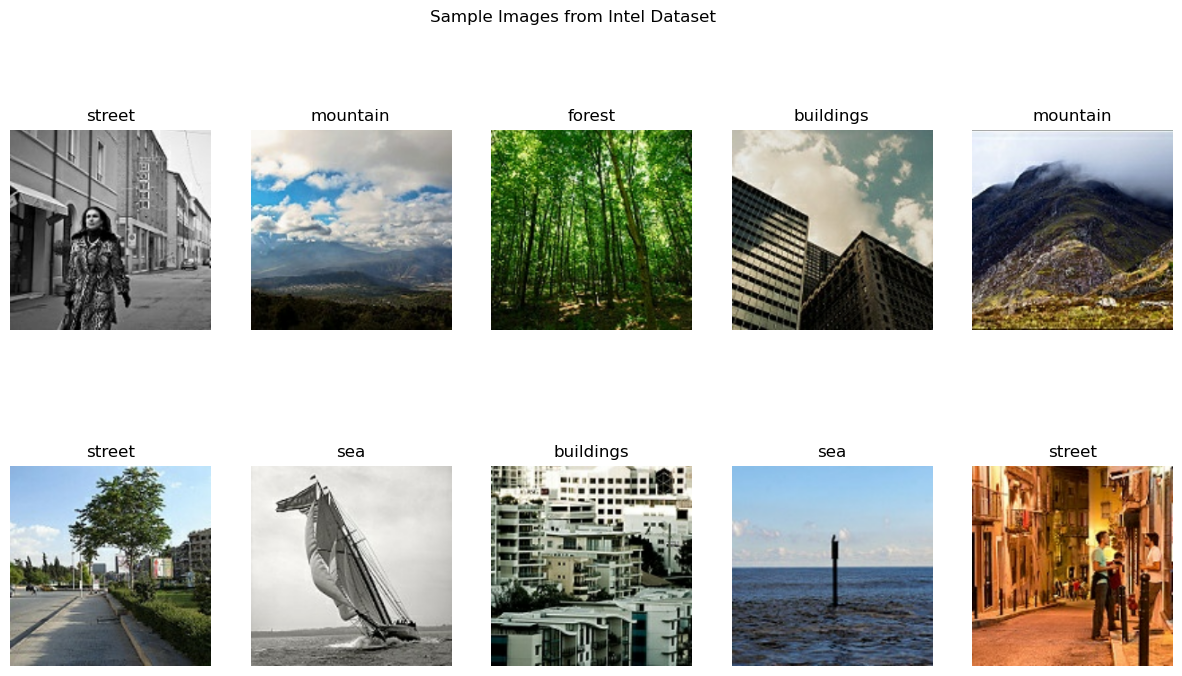

In [6]:
# Display sample images from training dataset
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.suptitle("Sample Images from Intel Dataset")
plt.show()


NORMALISE DATA

In [7]:
# Normalize pixel values to range [0, 1]
normalise = layers.Rescaling(1./255)

# Apply normalization to training and validation datasets
train_ds = train_ds.map(lambda x, y: (normalise(x), y))
val_ds   = val_ds.map(lambda x, y: (normalise(x), y))


SIMPLE CNN MODEL (BASELINE)

In [8]:
# Build baseline CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(224,224,3)),  # Input size for images
    
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),         # Convert feature maps to vector
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),      # Prevent overfitting
    layers.Dense(NUM_CLASSES, activation="softmax") # Output layer
])
# Compile CNN model
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN CNN

In [9]:
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 336s 759ms/step - accuracy: 0.4889 - loss: 1.3004 - val_accuracy: 0.6530 - val_loss: 0.8642
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 317s 722ms/step - accuracy: 0.6805 - loss: 0.8465 - val_accuracy: 0.7207 - val_loss: 0.7305
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 317s 723ms/step - accuracy: 0.7571 - loss: 0.6611 - val_accuracy: 0.8067 - val_loss: 0.5550
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 284s 645ms/step - accuracy: 0.8096 - loss: 0.5294 - val_accuracy: 0.7937 - val_loss: 0.6023
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 266s 605ms/step - accuracy: 0.8459 - loss: 0.4258 - val_accuracy: 0.7893 - val_loss: 0.6437


CNN CONFUSION MATRIX CODE

Predictions

In [11]:
import numpy as np

# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Model predictions
y_pred_probs = cnn_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step


PLOT TRAINING CURVES

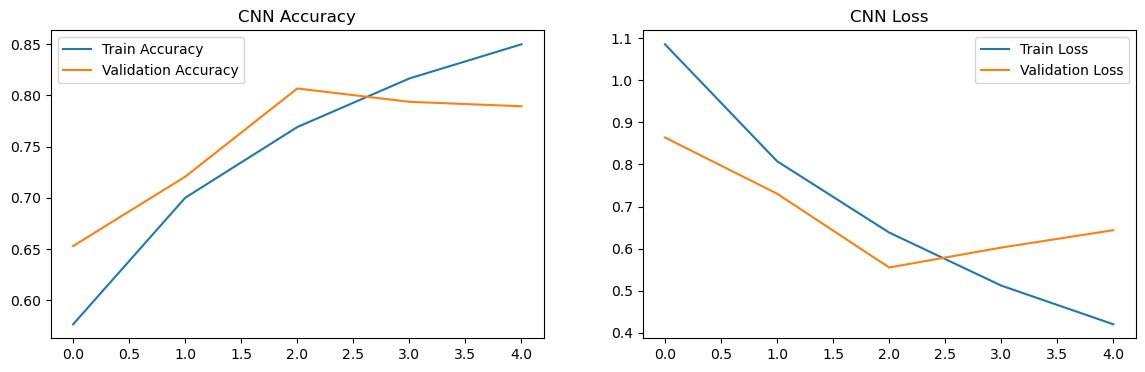

In [12]:
# CNN TRAINING CURVES

def plot_cnn_history(history):
    plt.figure(figsize=(14,4))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("CNN Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("CNN Loss")
    plt.legend()

    plt.show()

plot_cnn_history(cnn_history)

Confusion Matrix for CNN

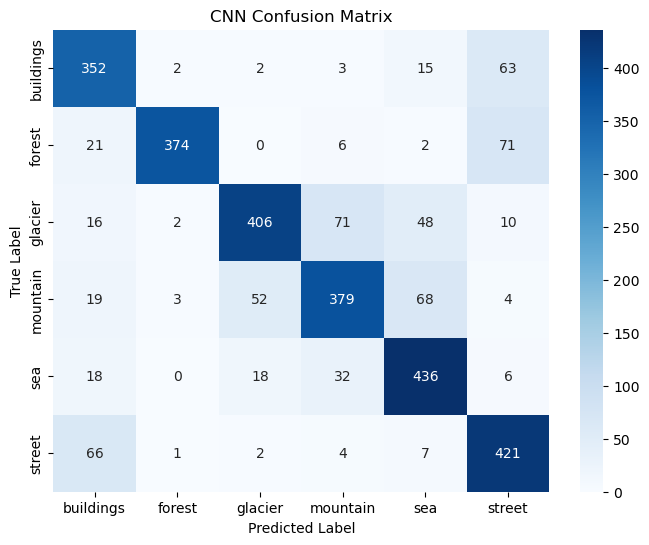

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CNN Confusion Matrix")
plt.show()


Classification Report for CNN

In [14]:
from sklearn.metrics import classification_report

print("CNN Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))


CNN Classification Report
              precision    recall  f1-score   support

   buildings       0.72      0.81      0.76       437
      forest       0.98      0.79      0.87       474
     glacier       0.85      0.73      0.79       553
    mountain       0.77      0.72      0.74       525
         sea       0.76      0.85      0.80       510
      street       0.73      0.84      0.78       501

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.79      0.79      3000



FINE-TUNED RESNET50 MODEL

In [15]:
# LOAD DATASET(ResNet version)
# Image size required by ResNet50
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define dataset paths
train_dir = os.path.join(EXTRACT_PATH, "seg_train", "seg_train")
test_dir  = os.path.join(EXTRACT_PATH, "seg_test", "seg_test")

# Load training dataset
train_ds_resnet = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load validation dataset
val_ds_resnet = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)




Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [16]:
# DATA AUGMENTATION

# Apply random transformations to improve generalisation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply augmentation only to training data
train_ds_resnet = train_ds_resnet.map(lambda x, y: (data_augmentation(x), y))

In [17]:
# PREPROCESS INPUT FOR RESNET

# Apply ImageNet-style preprocessing
from tensorflow.keras.applications.resnet50 import preprocess_input

train_ds_resnet = train_ds_resnet.map(lambda x, y: (preprocess_input(x), y))
val_ds_resnet   = val_ds_resnet.map(lambda x, y: (preprocess_input(x), y))

In [18]:
# PRETRAINED RESNET50 MODEL (SAFE FINE-TUNING)

# Load ResNet50 without final classifier
resnet_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze most layers, fine-tune last ones
for layer in resnet_base.layers[:-15]:
    layer.trainable = False

    # Build ResNet50-based model
resnet_model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    resnet_base,                     # Feature extractor
    layers.GlobalAveragePooling2D(), # Convert feature maps to vector
    layers.BatchNormalization(),     # Stabilise training
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),             # Reduce overfitting
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model with low learning rate for fine-tuning
resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,950 (91.01 MB)

 Trainable params: 5,787,526 (22.08 MB)

 Non-trainable params: 18,071,424 (68.94 MB)

In [19]:
# TRAIN MODEL

resnet_history = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=5
)

Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 648s 1s/step - accuracy: 0.4063 - loss: 1.8668 - val_accuracy: 0.8430 - val_loss: 0.4290
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 618s 1s/step - accuracy: 0.7763 - loss: 0.6576 - val_accuracy: 0.8863 - val_loss: 0.3140
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 618s 1s/step - accuracy: 0.8335 - loss: 0.4859 - val_accuracy: 0.9030 - val_loss: 0.2724
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 617s 1s/step - accuracy: 0.8574 - loss: 0.4227 - val_accuracy: 0.9100 - val_loss: 0.2502
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.8720 - loss: 0.3707 - val_accuracy: 0.9180 - val_loss: 0.2356


PLOT TRAINING CURVES

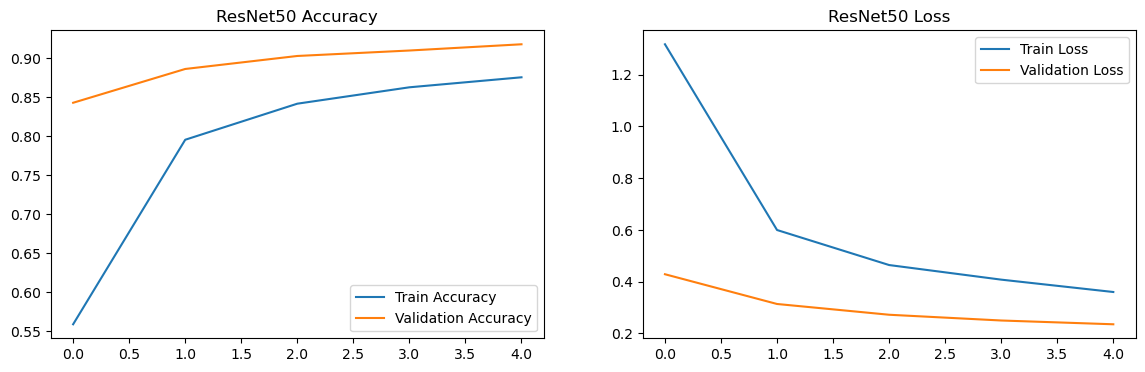

In [20]:
# RESNET50 TRAINING CURVES


def plot_resnet_history(history):
    plt.figure(figsize=(14,4))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("ResNet50 Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("ResNet50 Loss")
    plt.legend()

    plt.show()

plot_resnet_history(resnet_history)


In [21]:
# EVALUATE RESNET MODEL 
y_true = np.concatenate([y for x, y in val_ds_resnet], axis=0)

y_pred_probs = resnet_model.predict(val_ds_resnet)
y_pred = np.argmax(y_pred_probs, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step


CONFUSION MATRIX & CLASSIFICATION REPORT

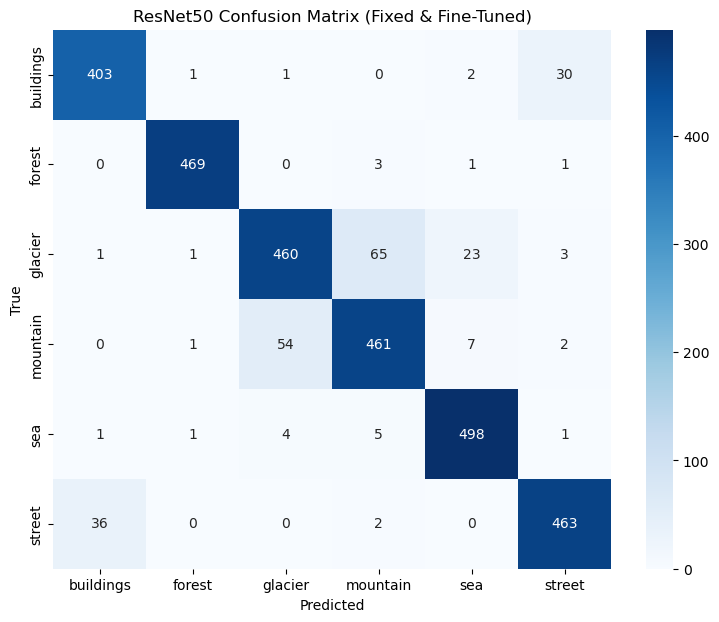


ResNet50 Classification Report

              precision    recall  f1-score   support

   buildings       0.91      0.92      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.89      0.83      0.86       553
    mountain       0.86      0.88      0.87       525
         sea       0.94      0.98      0.96       510
      street       0.93      0.92      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [22]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9,7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet50 Confusion Matrix (Fixed & Fine-Tuned)")
plt.show()

# CLASSIFICATION REPORT


print("\nResNet50 Classification Report\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


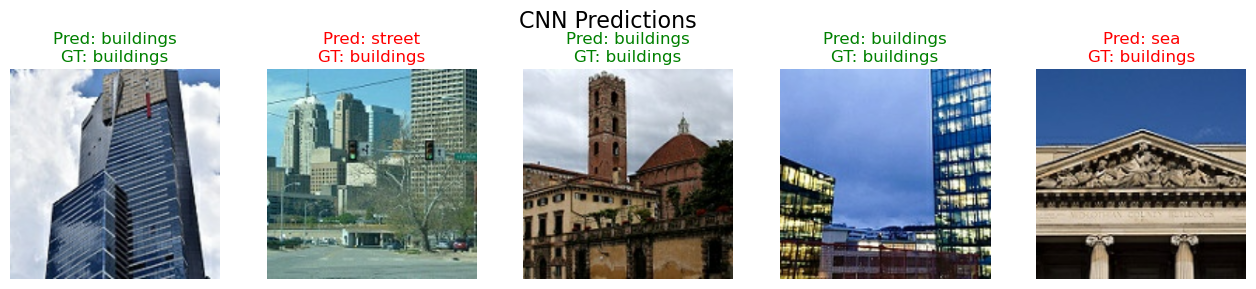

In [30]:
#Predictions — CNN Model

def show_predictions(model, dataset, title, class_names, n=10):
    plt.figure(figsize=(16,6))
    
    images, labels = next(iter(dataset))
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.axis("off")

        true = class_names[labels[i]]
        pred = class_names[pred_labels[i]]
        color = "green" if true == pred else "red"

        plt.title(f"Pred: {pred}\nGT: {true}", color=color)

    plt.suptitle(title, fontsize=16)
    plt.show()


# ---- SHOW CNN PREDICTIONS ----
show_predictions(cnn_model, val_ds, 
                 title="CNN Predictions", 
                 class_names=class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


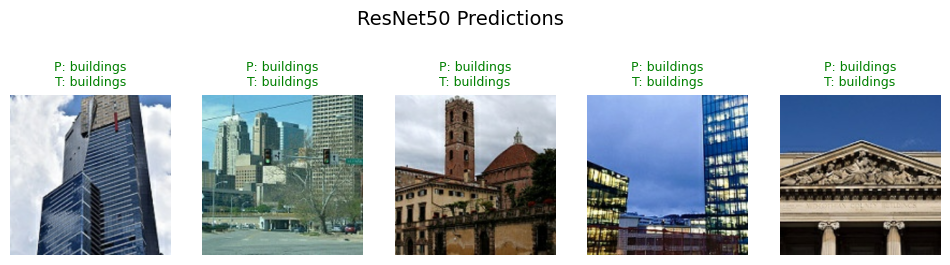

In [29]:
#Predictions — ResNet50 Model

def resnet_unprocess(img):
    img = img.copy()
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    img = img[..., ::-1]   # BGR → RGB
    img = np.clip(img / 255.0, 0, 1)
    return img


def show_predictions(model, dataset, title, resnet=False):
    plt.figure(figsize=(12,6))
    
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        
        for i in range(5):
            plt.subplot(2,5,i+1)
            
            if resnet:
                img = resnet_unprocess(images[i].numpy())
            else:
                img = images[i].numpy()
            
            plt.imshow(img)
            pred = class_names[np.argmax(preds[i])]
            true = class_names[labels[i]]
            
            color = "green" if pred==true else "red"
            plt.title(f"P: {pred}\nT: {true}", color=color, fontsize=9)
            plt.axis("off")
        
    plt.suptitle(title, fontsize=14)
    plt.show()


# ---- SHOW RESNET PREDICTIONS ----
show_predictions(resnet_model, val_ds_resnet, "ResNet50 Predictions", resnet=True)
